In [1]:
import os
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml  
import json  

from datetime import datetime
from dotenv import load_dotenv
from dataclasses import dataclass, asdict
from typing import Dict, List, Any, Optional, TypedDict
from concurrent.futures import ThreadPoolExecutor, as_completed

from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import JsonOutputParser  
from langchain_core.pydantic_v1 import BaseModel, Field  

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")

with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)

c:\Users\Kevin Nathanael\anaconda3\envs\torch\lib\site-packages\IPython\core\interactiveshell.py:3577: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


# State and Data Classes

In [2]:
@dataclass
class AgentResult:
    agent_id: str
    agent_name: str
    timestamp: datetime
    features_analyzed: List[str]
    calculations: Dict[str, Any]
    findings: Dict[str, Any]
    anomaly_detected: bool
    anomaly_score: float
    anomaly_reasons: List[str]
    confidence_level: float
    
    def to_dict(self) -> Dict[str, Any]:
        """Convert to dictionary for JSON serialization."""
        result = asdict(self)
        result['timestamp'] = self.timestamp.isoformat()
        return result

@dataclass
class SupervisorDecision:
    session_id: str
    timestamp: datetime
    overall_anomaly: bool
    risk_level: str
    agent_results: List[AgentResult]
    recommendations: List[str]
    global_anomaly_score: float
    critical_issues: List[str]
    
    def to_dict(self) -> Dict[str, Any]:
        """Convert to dictionary for JSON serialization."""
        return {
            'session_id': self.session_id,
            'timestamp': self.timestamp.isoformat(),
            'overall_anomaly': self.overall_anomaly,
            'risk_level': self.risk_level,
            'agent_results': [result.to_dict() for result in self.agent_results],
            'recommendations': self.recommendations,
            'global_anomaly_score': self.global_anomaly_score,
            'critical_issues': self.critical_issues
        }

class AgentState(TypedDict):
    session_id: str
    input_data: Dict[str, Any]
    agent_results: Dict[str, AgentResult]
    supervisor_decision: Optional[SupervisorDecision]
    timestamp: str
    processing_status: str
    errors: List[str]

# All Agent Implementation

In [3]:
class AgentAnalysis(BaseModel):
    anomaly_detected: bool = Field(description="True if an anomaly is detected, otherwise False.")
    anomaly_score: float = Field(description="A score from 0.0 (no anomaly) to 1.0 (severe anomaly).")
    anomaly_reasons: List[str] = Field(description="A list of strings explaining the reasons for the anomaly.")
    findings: str = Field(description="A brief, one-sentence summary of the agent's key finding.")

class BaseAgent:
    def __init__(self, 
                 agent_id: str, 
                 name: str, 
                 features: List[str], 
                 llm: ChatOpenAI, 
                 prompt_template: str):
        self.agent_id = agent_id
        self.name = name
        self.features = features
        self.llm = llm
        self.prompt_template = prompt_template
        # The parser is configured to expect a JSON object that matches our AgentAnalysis model.
        self.parser = JsonOutputParser(pydantic_object=AgentAnalysis)

    def analyze(self, data_row: Dict) -> AgentResult:
        raise NotImplementedError("Subclasses must implement the analyze method.")

    def safe_analyze(self, data_row: Dict) -> AgentResult:
        try:
            return self.analyze(data_row)
        except Exception as e:
            logger.error(f"Error in {self.name}: {str(e)}")
            # Return a default error result if the analysis fails for any reason.
            return AgentResult(
                agent_id=self.agent_id,
                agent_name=self.name,
                timestamp=datetime.now(),
                features_analyzed=self.features,
                calculations={},
                findings={"error": f"LLM analysis failed: {str(e)}"},
                anomaly_detected=True,
                anomaly_score=1.0,
                anomaly_reasons=[f"Agent execution failed: {str(e)}"],
                confidence_level=0.0
            )

### Agent 1: Geolocation & Movement Analysis

Handles:
- `timestamp`
- `vehicle_gps_latitude`
- `vehicle_gps_longitude`
- `eta_variation_hours`
- `delivery_time_deviation`
- `delay_probability`
- `route_risk_level`

Tasks:
- Analyze route deviations.
- Compare expected vs actual location paths.
- Predict delay probabilities.
- Detect risky routes.
- Anomaly = unexpected movement, excessive deviation, high delay probability.

In [4]:
class GeolocationMovementAgent(BaseAgent):
    def analyze(self, data_row: Dict) -> AgentResult:
        """Analyzes data using the assigned LLM and prompt from the config."""
        # Filter the input data to only include features relevant to this agent.
        data_input = {k: data_row.get(k) for k in self.features if k in data_row}

        # Create the prompt using the template from the config file.
        prompt = ChatPromptTemplate.from_template(
            template=self.prompt_template,
            # This partial variable injects the JSON format instructions into the prompt.
            partial_variables={"format_instructions": self.parser.get_format_instructions()}
        )
        
        # Define the LangChain execution chain.
        chain = prompt | self.llm | self.parser

        # Invoke the chain to get the structured analysis from the LLM.
        analysis_result = chain.invoke({"data_input": json.dumps(data_input)})

        # Populate and return the standard AgentResult object with the LLM's findings.
        return AgentResult(
            agent_id=self.agent_id,
            agent_name=self.name,
            timestamp=datetime.now(),
            features_analyzed=self.features,
            calculations=data_input, # Store the raw input as calculations for transparency.
            findings=analysis_result, # The entire structured JSON response is the finding.
            anomaly_detected=analysis_result.get('anomaly_detected', False),
            anomaly_score=analysis_result.get('anomaly_score', 0.0),
            anomaly_reasons=analysis_result.get('anomaly_reasons', []),
            confidence_level=0.90 # High confidence as it's from a specialized LLM prompt.
        )

### Agent 2: Fuel & Environmental Impact

Handles:
- `fuel_consumption_rate`
- `weather_condition_severity`
- `traffic_congestion_level`

Tasks:
- Check if fuel usage is within expected range for distance + traffic.
- Assess whether weather or traffic justifies delays.    
- Anomaly = high consumption without external justification.

In [5]:
class FuelEnvironmentalAgent(BaseAgent):
    def analyze(self, data_row: Dict) -> AgentResult:
        data_input = {k: data_row.get(k) for k in self.features if k in data_row}
        prompt = ChatPromptTemplate.from_template(
            template=self.prompt_template,
            partial_variables={"format_instructions": self.parser.get_format_instructions()}
        )
        chain = prompt | self.llm | self.parser
        analysis_result = chain.invoke({"data_input": json.dumps(data_input)})
        return AgentResult(
            agent_id=self.agent_id, agent_name=self.name, timestamp=datetime.now(),
            features_analyzed=self.features, calculations=data_input, findings=analysis_result,
            anomaly_detected=analysis_result.get('anomaly_detected', False),
            anomaly_score=analysis_result.get('anomaly_score', 0.0),
            anomaly_reasons=analysis_result.get('anomaly_reasons', []),
            confidence_level=0.90
        )

### Agent 3: Logistics & Supply Chain Operations

Handles:
- `warehouse_inventory_level`
- `loading_unloading_time`
- `handling_equipment_availability`
- `port_congestion_level`
- `customs_clearance_time`

Tasks:
- Evaluate bottlenecks at physical touchpoints.
- Match equipment availability to actual loading times.
- Detect congestion-induced slowdowns.

In [6]:
class LogisticsSupplyChainAgent(BaseAgent):
    def analyze(self, data_row: Dict) -> AgentResult:
        data_input = {k: data_row.get(k) for k in self.features if k in data_row}
        prompt = ChatPromptTemplate.from_template(
            template=self.prompt_template,
            partial_variables={"format_instructions": self.parser.get_format_instructions()}
        )
        chain = prompt | self.llm | self.parser
        analysis_result = chain.invoke({"data_input": json.dumps(data_input)})
        return AgentResult(
            agent_id=self.agent_id, agent_name=self.name, timestamp=datetime.now(),
            features_analyzed=self.features, calculations=data_input, findings=analysis_result,
            anomaly_detected=analysis_result.get('anomaly_detected', False),
            anomaly_score=analysis_result.get('anomaly_score', 0.0),
            anomaly_reasons=analysis_result.get('anomaly_reasons', []),
            confidence_level=0.90
        )

### Agent 4: Order & Supplier Analysis
 
Handles:
- `order_fulfillment_status`
- `shipping_costs`
- `supplier_reliability_score`
- `lead_time_days`
- `historical_demand`

Tasks:
- Check if supplier metrics align with fulfillment delays.
- Evaluate cost anomalies.
- Match actual lead times vs historical norms.

In [7]:
class OrderSupplierAgent(BaseAgent):
    def analyze(self, data_row: Dict) -> AgentResult:
        data_input = {k: data_row.get(k) for k in self.features if k in data_row}
        prompt = ChatPromptTemplate.from_template(
            template=self.prompt_template,
            partial_variables={"format_instructions": self.parser.get_format_instructions()}
        )
        chain = prompt | self.llm | self.parser
        analysis_result = chain.invoke({"data_input": json.dumps(data_input)})
        return AgentResult(
            agent_id=self.agent_id, agent_name=self.name, timestamp=datetime.now(),
            features_analyzed=self.features, calculations=data_input, findings=analysis_result,
            anomaly_detected=analysis_result.get('anomaly_detected', False),
            anomaly_score=analysis_result.get('anomaly_score', 0.0),
            anomaly_reasons=analysis_result.get('anomaly_reasons', []),
            confidence_level=0.90
        )

### Agent 5: Cargo & IoT Monitoring

Handles:
- `iot_temperature`
- `cargo_condition_status`

Tasks:
- Monitor temperature and cargo status for anomalies.    
- Detect sensor failure or out-of-range readings.

In [8]:
class CargoIoTAgent(BaseAgent):
    def analyze(self, data_row: Dict) -> AgentResult:
        data_input = {k: data_row.get(k) for k in self.features if k in data_row}
        prompt = ChatPromptTemplate.from_template(
            template=self.prompt_template,
            partial_variables={"format_instructions": self.parser.get_format_instructions()}
        )
        chain = prompt | self.llm | self.parser
        analysis_result = chain.invoke({"data_input": json.dumps(data_input)})
        return AgentResult(
            agent_id=self.agent_id, agent_name=self.name, timestamp=datetime.now(),
            features_analyzed=self.features, calculations=data_input, findings=analysis_result,
            anomaly_detected=analysis_result.get('anomaly_detected', False),
            anomaly_score=analysis_result.get('anomaly_score', 0.0),
            anomaly_reasons=analysis_result.get('anomaly_reasons', []),
            confidence_level=0.90
        )

### Agent 6: Human Factors & Risk

Handles:
- `driver_behavior_score`
- `fatigue_monitoring_score`
- `disruption_likelihood_score`
- `risk_classification`

Tasks:
- Evaluate human error potential.
- Calculate operational risk.
- Use these to contextualize anomalies from other agents.

In [9]:
class HumanFactorsRiskAgent(BaseAgent):
    def analyze(self, data_row: Dict) -> AgentResult:
        data_input = {k: data_row.get(k) for k in self.features if k in data_row}
        prompt = ChatPromptTemplate.from_template(
            template=self.prompt_template,
            partial_variables={"format_instructions": self.parser.get_format_instructions()}
        )
        chain = prompt | self.llm | self.parser
        analysis_result = chain.invoke({"data_input": json.dumps(data_input)})
        return AgentResult(
            agent_id=self.agent_id, agent_name=self.name, timestamp=datetime.now(),
            features_analyzed=self.features, calculations=data_input, findings=analysis_result,
            anomaly_detected=analysis_result.get('anomaly_detected', False),
            anomaly_score=analysis_result.get('anomaly_score', 0.0),
            anomaly_reasons=analysis_result.get('anomaly_reasons', []),
            confidence_level=0.90
        )

### Supervisor Agent

In [10]:
from langchain_core.output_parsers import StrOutputParser 

class SupervisorAgent:
    """
    [REVISED] The AI-native supervisor agent.
    It initializes and manages a team of specialized AI worker agents,
    aggregates their findings, and uses its own LLM to generate a final,
    synthesized set of recommendations.
    """
    def __init__(self, config: Dict):
        self.config = config
        
        # --- 1. Instantiate the correct LLMs from the config file ---
        if not openai_api_key:
            logger.warning("OpenAI API key not found. LLM functionalities will be disabled.")
            self.supervisor_llm = None
            self.worker_llm = None
        else:
            # A more powerful model for the supervisor to handle synthesis and reasoning.
            self.supervisor_llm = ChatOpenAI(model=config['supervisor_model'], temperature=0.4)
            # A fast, efficient model for the specialized worker agents.
            self.worker_llm = ChatOpenAI(model=config['worker_model'], temperature=0.1)

        # --- 2. Dynamically create the team of AI-native worker agents ---
        self.agents = {
            'geolocation': GeolocationMovementAgent(
                agent_id="agent_1", name="Geolocation & Movement Analysis", llm=self.worker_llm,
                features=config['agent_1_geolocation']['features'], 
                prompt_template=config['agent_1_geolocation']['prompt']
            ),
            'fuel_env': FuelEnvironmentalAgent(
                agent_id="agent_2", name="Fuel & Environmental Impact", llm=self.worker_llm,
                features=config['agent_2_fuel']['features'], 
                prompt_template=config['agent_2_fuel']['prompt']
            ),
            'logistics': LogisticsSupplyChainAgent(
                agent_id="agent_3", name="Logistics & Supply Chain Operations", llm=self.worker_llm,
                features=config['agent_3_logistics']['features'], 
                prompt_template=config['agent_3_logistics']['prompt']
            ),
            'order_supplier': OrderSupplierAgent(
                agent_id="agent_4", name="Order & Supplier Analysis", llm=self.worker_llm,
                features=config['agent_4_supplier']['features'], 
                prompt_template=config['agent_4_supplier']['prompt']
            ),
            'cargo_iot': CargoIoTAgent(
                agent_id="agent_5", name="Cargo & IoT Monitoring", llm=self.worker_llm,
                features=config['agent_5_cargo']['features'], 
                prompt_template=config['agent_5_cargo']['prompt']
            ),
            'human_risk': HumanFactorsRiskAgent(
                agent_id="agent_6", name="Human Factors & Risk", llm=self.worker_llm,
                features=config['agent_6_risk']['features'], 
                prompt_template=config['agent_6_risk']['prompt']
            )
        }
    
    def process_data(self, data_row: Dict[str, Any], session_id: str) -> SupervisorDecision:
        """Process data through all agents and make a final decision."""
        agent_results = []
        
        # Run all agents in parallel for performance.
        with ThreadPoolExecutor(max_workers=len(self.agents)) as executor:
            future_to_agent = {
                executor.submit(agent.safe_analyze, data_row): agent_name
                for agent_name, agent in self.agents.items()
            }
            for future in as_completed(future_to_agent):
                try:
                    result = future.result()
                    agent_results.append(result)
                except Exception as e:
                    # Handle potential errors during future.result() call
                    agent_name = future_to_agent[future]
                    logger.error(f"Agent {agent_name} analysis failed with exception: {str(e)}")
                    # Create a specific error result if an agent crashes entirely
                    error_result = AgentResult(
                        agent_id=agent_name, agent_name=self.agents[agent_name].name,
                        timestamp=datetime.now(), features_analyzed=self.agents[agent_name].features,
                        calculations={}, findings={}, anomaly_detected=True, anomaly_score=1.0,
                        anomaly_reasons=[f"Agent execution crashed: {str(e)}"], confidence_level=0.0
                    )
                    agent_results.append(error_result)
        
        return self._make_final_decision(agent_results, session_id)
    
    def _make_final_decision(self, agent_results: List[AgentResult], session_id: str) -> SupervisorDecision:
        """This rule-based aggregation logic remains a valuable part of the system."""
        if not agent_results:
            # ... (error handling for no results is the same)
            return SupervisorDecision(...)

        # Calculate global metrics from the AI agents' scores
        anomaly_scores = [r.anomaly_score for r in agent_results]
        avg_anomaly_score = np.mean(anomaly_scores) if anomaly_scores else 0
        max_anomaly_score = max(anomaly_scores) if anomaly_scores else 0
        anomaly_count = sum(1 for r in agent_results if r.anomaly_detected)
        
        # Enhanced risk assessment based on aggregated scores
        if max_anomaly_score >= 0.8 or anomaly_count >= 4:
            risk_level = "HIGH"
        elif avg_anomaly_score >= 0.5 or anomaly_count >= 3:
            risk_level = "MODERATE"
        else:
            risk_level = "LOW"
        
        overall_anomaly = any(r.anomaly_detected for r in agent_results)
        
        # --- 3. Generate final recommendations using the supervisor's LLM ---
        if self.supervisor_llm:
            recommendations = self._generate_recommendations_llm(agent_results, risk_level)
        else:
            recommendations = ["LLM is not available. Please check API key."]

        critical_issues = self._identify_critical_issues(agent_results)
        
        return SupervisorDecision(
            session_id=session_id, timestamp=datetime.now(),
            overall_anomaly=overall_anomaly, risk_level=risk_level,
            agent_results=agent_results, recommendations=recommendations,
            global_anomaly_score=avg_anomaly_score, critical_issues=critical_issues
        )
    
    def _generate_recommendations_llm(self, agent_results: List[AgentResult], risk_level: str) -> List[str]:
        """[NEW] Generate final recommendations using the supervisor's LLM."""
        report_summary = ""
        for result in agent_results:
            if result.anomaly_detected:
                report_summary += (
                    f"- Agent '{result.agent_name}' detected an anomaly (Score: {result.anomaly_score:.2f}).\n"
                    f"  Finding: {result.findings.get('findings', 'N/A')}\n"
                    f"  Reasons: {'; '.join(result.anomaly_reasons)}\n"
                )

        if not report_summary:
            return ["All agent analyses are normal. Continue standard monitoring."]

        prompt = ChatPromptTemplate.from_template(self.config['supervisor']['prompt'])
        chain = prompt | self.supervisor_llm | StrOutputParser()
        
        try:
            llm_response = chain.invoke({"risk_level": risk_level, "report_summary": report_summary})
            recommendations = [rec.strip().lstrip('-* ') for rec in llm_response.strip().split('\n') if rec.strip()]
            return recommendations[:8]
        except Exception as e:
            logger.error(f"Supervisor LLM failed: {e}")
            return ["Error: Could not generate AI recommendations."]

    def _identify_critical_issues(self, agent_results: List[AgentResult]) -> List[str]:
        """This logic remains the same: it identifies the most severe issues based on score."""
        critical_issues = []
        for result in agent_results:
            if result.anomaly_score >= 0.8:
                critical_issues.extend([
                    f"CRITICAL: {result.agent_name} - {reason}" 
                    for reason in result.anomaly_reasons
                ])
        return critical_issues

# Workflow Nodes

In [11]:
class MultiAgentSupplyChainSystem:
    """
    [REVISED] Main system class for processing supply chain data.
    This class now initializes and manages the AI-native supervisor.
    """
    
    def __init__(self, config: Dict):
        # --- CRITICAL CHANGE ---
        # The supervisor is now initialized with the global config file,
        # which allows it to set up all the AI models and worker agents correctly.
        self.supervisor = SupervisorAgent(config)
        
        # The rest of the initialization remains the same.
        self.sessions = []
        self.processing_stats = {
            'total_processed': 0,
            'anomalies_detected': 0,
            'errors': 0,
            'processing_time': []
        }
    
    def process_single_row(self, data_row: Dict[str, Any]) -> Dict[str, Any]:
        """
        Process a single row of data. This method's logic remains the same,
        but it now triggers a fully AI-driven analysis pipeline.
        """
        start_time = datetime.now()
        session_id = f"session_{start_time.timestamp()}"
        
        try:
            # Process through the AI-native supervisor.
            decision = self.supervisor.process_data(data_row, session_id)
            
            # The result structure is unchanged.
            result = {
                'session_id': session_id,
                'input_data': data_row,
                'supervisor_decision': decision.to_dict(),
                'processing_time': (datetime.now() - start_time).total_seconds(),
                'status': 'SUCCESS'
            }
            
            # Update stats.
            self.processing_stats['total_processed'] += 1
            if decision.overall_anomaly:
                self.processing_stats['anomalies_detected'] += 1
            
            self.sessions.append(result)
            return result
            
        except Exception as e:
            logger.error(f"Error processing row: {str(e)}")
            self.processing_stats['errors'] += 1
            
            error_result = {
                'session_id': session_id,
                'input_data': data_row,
                'supervisor_decision': None,
                'processing_time': (datetime.now() - start_time).total_seconds(),
                'status': 'ERROR',
                'error': str(e)
            }
            
            self.sessions.append(error_result)
            return error_result
    
    def process_batch(self, df: pd.DataFrame, max_workers: int = 4) -> List[Dict[str, Any]]:
        """This powerful parallel processing method remains unchanged."""
        results = []
        
        if len(df) == 0:
            logger.warning("Empty DataFrame provided")
            return results
        
        start_time = datetime.now()
        logger.info(f"Processing batch of {len(df)} rows with {max_workers} workers")
        
        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            future_to_row = {
                executor.submit(self.process_single_row, row.to_dict()): idx
                for idx, row in df.iterrows()
            }
            for future in as_completed(future_to_row):
                row_idx = future_to_row[future]
                try:
                    result = future.result()
                    results.append(result)
                except Exception as e:
                    logger.error(f"Failed to process row {row_idx}: {str(e)}")
                    self.processing_stats['errors'] += 1
        
        results.sort(key=lambda x: x['session_id'])
        
        total_time = (datetime.now() - start_time).total_seconds()
        logger.info(f"Batch processing completed in {total_time:.2f} seconds")
        
        return results
    
    def get_processing_summary(self) -> Dict[str, Any]:
        """This summary method remains unchanged."""
        # ... (code is identical to the original)
        return {
            'total_sessions': len(self.sessions),
            'successful_sessions': len([s for s in self.sessions if s['status'] == 'SUCCESS']),
            'failed_sessions': len([s for s in self.sessions if s['status'] == 'ERROR']),
            'anomalies_detected': self.processing_stats['anomalies_detected'],
            'anomaly_rate': (self.processing_stats['anomalies_detected'] / 
                           max(self.processing_stats['total_processed'], 1)) * 100,
            'avg_processing_time': np.mean([s['processing_time'] for s in self.sessions if 'processing_time' in s]) if self.sessions else 0
        }
    
    def get_anomaly_report(self) -> pd.DataFrame:
        """This reporting method remains unchanged."""
        # ... (code is identical to the original)
        anomaly_data = []
        for session in self.sessions:
            if session.get('status') == 'SUCCESS' and session.get('supervisor_decision'):
                decision = session['supervisor_decision']
                if decision['overall_anomaly']:
                    anomaly_data.append({
                        'session_id': session['session_id'],
                        'risk_level': decision['risk_level'],
                        'anomaly_score': decision['global_anomaly_score'],
                        'agents_with_anomalies': len([r for r in decision['agent_results'] if r['anomaly_detected']]),
                        'critical_issues': len(decision['critical_issues']),
                        'recommendations': len(decision['recommendations'])
                    })
        return pd.DataFrame(anomaly_data) if anomaly_data else pd.DataFrame()

    def export_results(self, filepath: str = None) -> str:
        """This export method remains unchanged."""
        # ... (code is identical to the original)
        if filepath is None:
            filepath = f"supply_chain_results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
        export_data = {
            'processing_summary': self.get_processing_summary(),
            'sessions': self.sessions,
            'export_timestamp': datetime.now().isoformat()
        }
        with open(filepath, 'w') as f:
            json.dump(export_data, f, indent=2, default=str)
        logger.info(f"Results exported to {filepath}")
        return filepath

# Main Execution and Results Analysis

In [12]:
def create_visualization_dashboard(system: 'MultiAgentSupplyChainSystem'):
    """Creates and displays a dashboard of plots summarizing the system's results."""
    
    # Ensure there are results to plot
    successful_sessions = [s for s in system.sessions if s['status'] == 'SUCCESS' and s['supervisor_decision']]
    if not successful_sessions:
        print("\nNo successful sessions with data to visualize.")
        return

    # --- Data Preparation ---
    agent_names = list(system.supervisor.agents.keys())
    anomaly_counts_by_agent = {name: 0 for name in agent_names}
    anomaly_scores_by_agent = {name: [] for name in agent_names}
    risk_level_counts = {'HIGH': 0, 'MODERATE': 0, 'LOW': 0, 'MINIMAL': 0}

    for session in successful_sessions:
        decision = session['supervisor_decision']
        risk_level_counts[decision['risk_level']] += 1
        for agent_result in decision['agent_results']:
            agent_id = agent_result['agent_id']
            # Find the agent key from its ID (e.g., 'agent_1' -> 'geolocation')
            agent_key = next((key for key, agent in system.supervisor.agents.items() if agent.agent_id == agent_id), None)
            if agent_key:
                if agent_result['anomaly_detected']:
                    anomaly_counts_by_agent[agent_key] += 1
                anomaly_scores_by_agent[agent_key].append(agent_result['anomaly_score'])

    # Calculate average scores
    avg_scores = {agent: np.mean(scores) if scores else 0 for agent, scores in anomaly_scores_by_agent.items()}

    # --- Plotting ---
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    fig.suptitle('Multi-Agent System Analysis Dashboard', fontsize=20, weight='bold')

    # Plot 1: Anomaly Counts by Agent
    axes[0, 0].bar(anomaly_counts_by_agent.keys(), anomaly_counts_by_agent.values(), color='skyblue')
    axes[0, 0].set_title('Total Anomalies Detected by Agent', fontsize=14)
    axes[0, 0].set_ylabel('Number of Anomalies')
    axes[0, 0].tick_params(axis='x', rotation=45)

    # Plot 2: Average Anomaly Score by Agent
    axes[0, 1].bar(avg_scores.keys(), avg_scores.values(), color='salmon')
    axes[0, 1].set_title('Average Anomaly Score by Agent', fontsize=14)
    axes[0, 1].set_ylabel('Average Score')
    axes[0, 1].tick_params(axis='x', rotation=45)

    # Plot 3: Overall Risk Level Distribution
    risk_labels = [k for k, v in risk_level_counts.items() if v > 0]
    risk_values = [v for k, v in risk_level_counts.items() if v > 0]
    axes[1, 0].pie(risk_values, labels=risk_labels, autopct='%1.1f%%', startangle=140, colors=['#ff6666', '#ffcc66', '#99ff99', '#cceeff'])
    axes[1, 0].set_title('Overall Risk Level Distribution', fontsize=14)
    
    # Plot 4: Anomaly Report Table
    anomaly_report = system.get_anomaly_report()
    axes[1, 1].axis('off') # Hide axes for table
    if not anomaly_report.empty:
        table = axes[1, 1].table(cellText=anomaly_report.values, colLabels=anomaly_report.columns, loc='center', cellLoc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1.2, 1.2)
        axes[1, 1].set_title('Anomaly Report Summary', fontsize=14, pad=20)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


def main():
    """[REVISED] Main function to demonstrate the DYNAMIC AI-native system."""
    try:
        df = pd.read_csv('test_data.csv')
    except FileNotFoundError:
        print("🚨 ERROR: 'test_data.csv' not found. Please ensure the dataset is in the same directory.")
        return None, None
        
    if not config:
        print("🚨 ERROR: Configuration not loaded. Exiting.")
        return None, None
    
    print("\n🚀 Initializing DYNAMIC Multi-Agent Supply Chain System...")
    # Initialize the system with the global configuration
    system = MultiAgentSupplyChainSystem(config)
    
    # Process the entire DataFrame from the CSV
    results = system.process_batch(df)
    
    if not results:
        print("\nNo results were generated. Exiting.")
        return system, None
    
    # --- Display Processing Summary ---
    summary = system.get_processing_summary()
    print("\n📈 Processing Summary:")
    print(f"  • Total sessions: {summary['total_sessions']}")
    print(f"  • Successful sessions: {summary['successful_sessions']}")
    print(f"  • Failed sessions: {summary['failed_sessions']}")
    print(f"  • Anomalies detected: {summary['anomalies_detected']}")
    print(f"  • Anomaly rate: {summary['anomaly_rate']:.1f}%")
    print(f"  • Average processing time: {summary['avg_processing_time']:.3f} seconds")
    
    # --- Display Detailed Results for the first successful session ---
    successful_results = [r for r in results if r['status'] == 'SUCCESS']
    if successful_results:
        first_result = successful_results[0]
        decision = first_result['supervisor_decision']
        
        print(f"\n🔍 Detailed Analysis for Session {first_result['session_id']}:")
        print(f"  • Overall Anomaly: {'YES' if decision['overall_anomaly'] else 'NO'}")
        print(f"  • Risk Level: {decision['risk_level']}")
        print(f"  • Global Anomaly Score: {decision['global_anomaly_score']:.3f}")
        
        print("\n🤖 Agent Results (AI-Native Analysis):")
        for agent_result in decision['agent_results']:
            status = "🔴 ANOMALY" if agent_result['anomaly_detected'] else "✅ NORMAL"
            print(f"  • {agent_result['agent_name']}: {status} (Score: {agent_result['anomaly_score']:.3f})")
            # Display the new finding from the worker LLM
            print(f"    └── Finding: {agent_result['findings'].get('findings', 'N/A')}")

        print("\n💡 Recommendations (Generated by Supervisor LLM):")
        if decision['recommendations']:
            for i, rec in enumerate(decision['recommendations'], 1):
                print(f"  {i}. {rec}")
        
        if decision['critical_issues']:
            print("\n🚨 Critical Issues:")
            for i, issue in enumerate(decision['critical_issues'], 1):
                print(f"  {i}. {issue}")
    
    # Export results
    export_file = system.export_results()
    print(f"\n💾 Results exported to: {export_file}")
    
    return system, results


🚀 Initializing DYNAMIC Multi-Agent Supply Chain System...


INFO:__main__:Processing batch of 10 rows with 4 workers
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST htt


📈 Processing Summary:
  • Total sessions: 10
  • Successful sessions: 10
  • Failed sessions: 0
  • Anomalies detected: 10
  • Anomaly rate: 100.0%
  • Average processing time: 6.863 seconds

🔍 Detailed Analysis for Session session_1751617402.638556:
  • Overall Anomaly: YES
  • Risk Level: HIGH
  • Global Anomaly Score: 1.532

🤖 Agent Results (AI-Native Analysis):
  • Fuel & Environmental Impact: ✅ NORMAL (Score: 0.000)
    └── Finding: The fuel consumption rate is within the normal range (5.1365), and neither weather condition severity nor traffic congestion level justifies high consumption. Therefore, no anomaly is detected.
  • Human Factors & Risk: 🔴 ANOMALY (Score: 0.466)
    └── Finding: The low driver behavior score indicates a significant operational risk that is not aligned with the moderate risk classification.
  • Geolocation & Movement Analysis: 🔴 ANOMALY (Score: 0.800)
    └── Finding: The vehicle shows significant schedule deviation due to excessive delivery time deviat

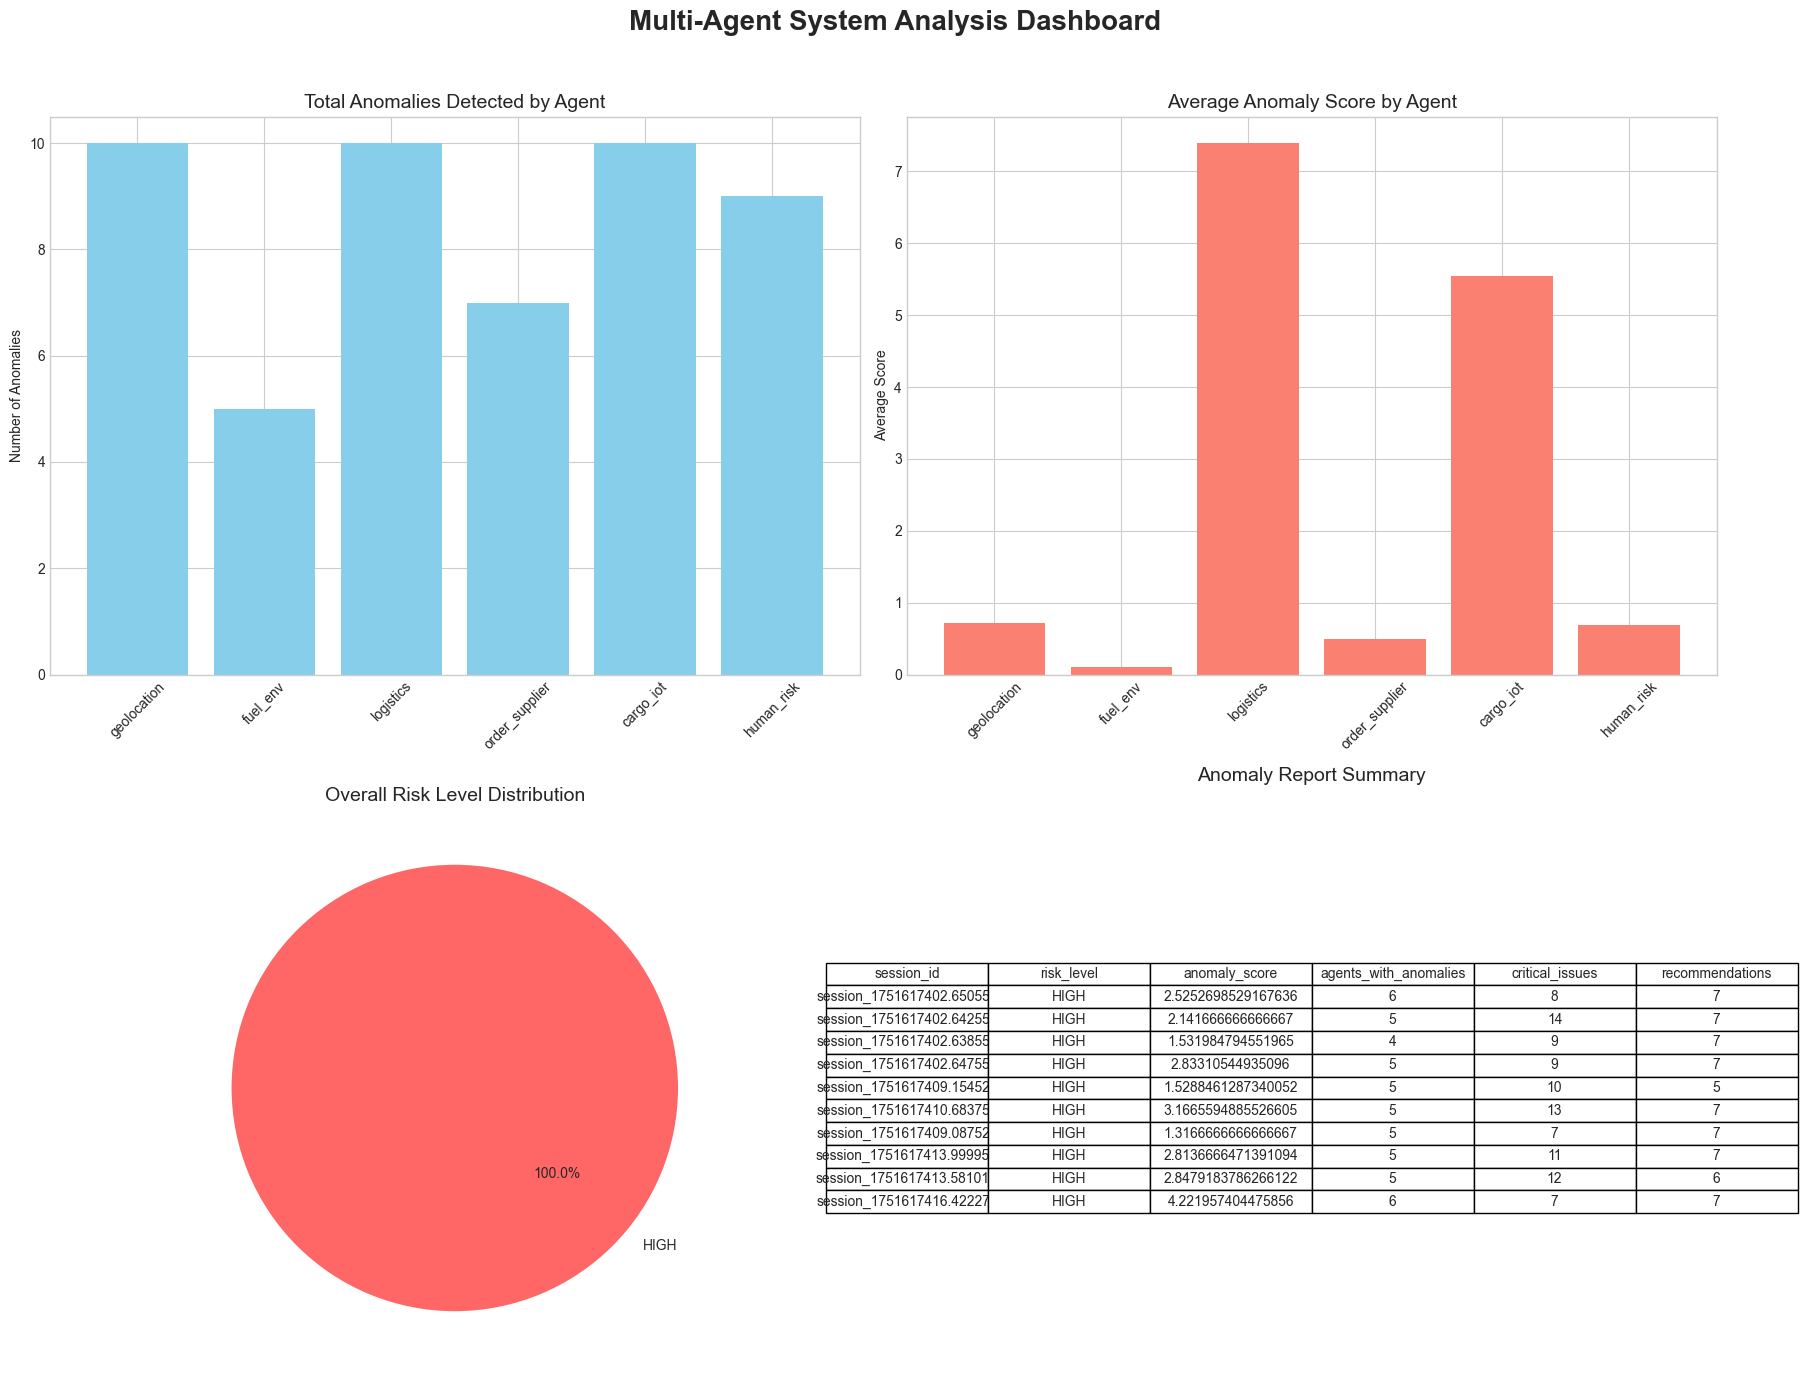


🎉 AI-Native Multi-Agent System execution completed successfully!

System Features:
✅ Dynamic analysis driven by LLMs (gpt-4o-mini & gpt-3.5-turbo).
✅ Agent behaviors are now controlled by prompts in 'config.yaml'.
✅ Parallel processing for high-performance batch analysis.
✅ Structured, predictable JSON outputs from agents.
✅ AI-generated, context-aware recommendations.
✅ Automated dashboard and JSON export.


In [13]:
if __name__ == "__main__" and 'config' in locals() and config is not None:
    system, results = main()
    
    if system:
        # Create visualization dashboard
        print("\n📊 Creating visualization dashboard...")
        create_visualization_dashboard(system)
    
    print("\n🎉 AI-Native Multi-Agent System execution completed successfully!")
    print("\nSystem Features:")
    print("✅ Dynamic analysis driven by LLMs (gpt-4o-mini & gpt-3.5-turbo).")
    print("✅ Agent behaviors are now controlled by prompts in 'config.yaml'.")
    print("✅ Parallel processing for high-performance batch analysis.")
    print("✅ Structured, predictable JSON outputs from agents.")
    print("✅ AI-generated, context-aware recommendations.")
    print("✅ Automated dashboard and JSON export.")